In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import MDAnalysis as mda
from MDAnalysis.coordinates import LAMMPS
from concurrent.futures import ProcessPoolExecutor
import traceback

In [2]:
def find_stop_displacement(t_thresh, t_step, df, d_thresh, window):
    count = 0
    offset = int(t_thresh / t_step)
    for i in range(df.shape[0]):
        if (i + offset) >= df.shape[0]:
            break
        x0, y0, z0 = df['x'].iloc[i], df['y'].iloc[i], df['z'].iloc[i]
        x1, y1, z1 = df['x'].iloc[i + offset], df['y'].iloc[i + offset], df['z'].iloc[i + offset]
        dist = np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2 + (z1 - z0) ** 2)
        if dist < d_thresh:
            count += 1
            if count >= window:
                return i - window + 1
        else:
            count = 0
    return df.shape[0] - 1

def find_stop(d, i, threshold):
    atom_style = 'id type x y z vx vy vz'
    u = mda.Universe(d.replace('com', 'atoms'), format='LAMMPSDUMP', atom_style=atom_style, lengthunit="nm", timeunit="ns")
    x, y, z = [], [], []
    for ts in u.trajectory:
        pos = u.atoms.positions
        x.append(pos[i, 0])
        y.append(pos[i, 1])
        z.append(pos[i, 2])
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df['displacement'] = np.sqrt(df['x'].diff() ** 2 + df['y'].diff() ** 2 + df['z'].diff() ** 2)
    for ind in range(1, len(df)):
        if df['displacement'][ind] < threshold:
            return ind
    return len(df) - 1

def read_bacteria_output(file_path):
    time_steps, c_bac_com_data, c_com_v_data = [], [], []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line.startswith('#') or not line:
                i += 1
                continue
            if len(line.split()) == 2:
                timestep, num_rows = map(int, line.split())
                i += 1
                for _ in range(num_rows):
                    if _ < (num_rows - 1):
                        i += 1
                    else:
                        row_data = list(map(float, lines[i].strip().split()))
                        time_steps.append(timestep)
                        c_bac_com_data.append(row_data[1:4])
                        c_com_v_data.append(row_data[4:7])
                        i += 1
            else:
                i += 1
    df = pd.DataFrame({
        'TimeStep': time_steps,
        'x': [d[0] for d in c_bac_com_data],
        'y': [d[1] for d in c_bac_com_data],
        'z': [d[2] for d in c_bac_com_data],
        'vx': [v[0] for v in c_com_v_data],
        'vy': [v[1] for v in c_com_v_data],
        'vz': [v[2] for v in c_com_v_data],
    })
    return df

def get_euclidean_distance(df_original, ind):
    df = df_original.copy()
    df['v'] = np.sqrt(df['vx'] ** 2 + df['vy'] ** 2 + df['vz'] ** 2)
    distances = np.sqrt(df['x'].diff() ** 2 + df['y'].diff() ** 2 + df['z'].diff() ** 2)
    for i in range(1, len(df)):
        if df['v'][i] <= 3e-5:
            break
    i = min(i, ind)
    pos0 = df.iloc[0][['x', 'y', 'z']].values
    pos_end = df.iloc[i][['x', 'y', 'z']].values
    end_to_end = np.linalg.norm(pos_end - pos0)
    traveled = distances[1:i + 1].sum()
    vs = df['v'][1:i]
    v_mean = vs.mean()
    rms = np.sqrt((vs ** 2).mean())
    return end_to_end, traveled, df['TimeStep'][i], v_mean, rms

def plot_trajectory_with_lines(df_original, end_to_end, traveled, filename, ind, v_nb=0.007):
    df = df_original.copy()
    j = len(df)
    df['speed'] = np.sqrt(df['vx'] ** 2 + df['vy'] ** 2 + df['vz'] ** 2)
    for i in range(1, len(df)):
        if df['speed'][i] <= 3e-5:
            break
    i = min(i, ind)
    df = df[:i]
    df['clipped_speed'] = np.clip(df['speed'], 0, v_nb) / v_nb
    norm = plt.Normalize(0, 1)
    colors = cm.viridis(norm(df['clipped_speed']))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(df) - 1):
        ax.plot(df['x'].iloc[i:i + 2], df['y'].iloc[i:i + 2], df['z'].iloc[i:i + 2], color=colors[i])
    sc = ax.scatter(df['x'], df['y'], df['z'], c=df['clipped_speed'], cmap='viridis', s=10)
    cbar = plt.colorbar(sc)
    cbar.set_label('Speed Norm', rotation=270, labelpad=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'COM Trajectory({i}/{j}), End-to-End Distance: {end_to_end:.2f}, Traveled Distance: {traveled:.2f}')
    ax.text(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], 't_start', color='red', fontsize=12, fontweight='bold')
    ax.text(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], 't_end', color='blue', fontsize=12, fontweight='bold')
    plt.savefig(filename, dpi=80, bbox_inches='tight')
    plt.close()
    return len(df)

def process_one_trajectory(d):
    try:
        df_name = os.path.basename(d).removesuffix('.com')
        ind1 = find_stop(d, 0, threshold=1e-3)
        ind2 = find_stop(d, 12, threshold=1e-3)
        df = read_bacteria_output(d)
        ind3 = find_stop_displacement(t_thresh=400000, t_step=10000, df=df, d_thresh=1, window=50)
        ind = min(ind1, ind2, ind3)
        ete, trv, t, v, r = get_euclidean_distance(df, ind=ind)
        img_path = str((Path(d).parent.parent / 'analysis' / (df_name + '.jpg')))
        if ind != 0:
            plot_trajectory_with_lines(df, ete, trv, img_path, ind=ind)
        return {'name': df_name, 'ete': ete, 'trv': trv, 't': t, 'v_mean': v, 'v_rms': r}
    except Exception as e:
        print(f"Failed processing {d}: {e}")
        traceback.print_exc()
        return None

In [4]:
d = "/scratch/gpfs/ziyangc/Curvature/mesh/newmodel/working/realistic/cur0.95/output/cur_2.5_1.0_0.5_1.2_1.com"

In [32]:
df_name = os.path.basename(d).removesuffix('.com')
ind1 = find_stop(d, 0, threshold=1e-3)
ind2 = find_stop(d, 12, threshold=1e-3)
df = read_bacteria_output(d)
ind3 = find_stop_displacement(t_thresh=400000, t_step=10000, df=df, d_thresh=2, window=50)
ind = min(ind1, ind2, ind3)
ete, trv, t, v, r = get_euclidean_distance(df, ind=ind)
ind1, ind2, ind3

/home/ziyangc/.conda/envs/curvature/lib/python3.12/site-packages/MDAnalysis/topology/LAMMPSParser.py:637: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/home/ziyangc/.conda/envs/curvature/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
/home/ziyangc/.conda/envs/curvature/lib/python3.12/site-packages/MDAnalysis/topology/LAMMPSParser.py:637: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/home/ziyangc/.conda/envs/curvature/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


(2000, 2000, 776)

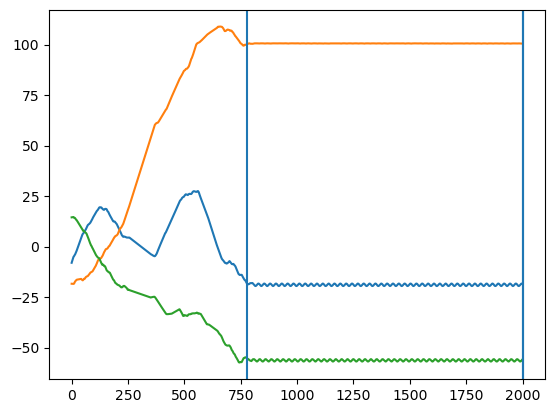

In [33]:
plt.plot(df['x'])
plt.plot(df['y'])
plt.plot(df['z'])
plt.axvline(ind1)
plt.axvline(ind2)
plt.axvline(ind3)